# Summary by task
Each task is unique, and how easily it can be solved by an LLM is likely dependent on the complexity of the problem, the number of times similar problems have been solved in the past, and the requirements of the solution.

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat as nbf
from collections import Counter

# Task complexity
To approximate task complexity, I've evaluated each task based on the following criteria:
1) Number of unique library imports.
2) Number of lines of code in the reference solution

We should expect that more difficult tasks will require more lines of code, as well as a higher number of unique library imports. These are not causal relationships, as 'task complexity' is likely made up of many independent variables. However, in the limit, we could imagine that a very complex problem will involve a lot of unique libraries and a lot of code, whereas a simple solution will require few libraries and only a few lines of code.

In [367]:
case_dir = "../test_cases"
cell_count = Counter()
line_count = Counter()

for k in os.listdir(case_dir):
    if k.endswith("ipynb"):
        ntbk = nbf.read(os.path.join(case_dir, k), nbf.NO_CONVERT)
        k = k.replace(".ipynb","")
        source = ntbk["cells"][0]["source"]
        for line in source.split("\n"):
            #print(line) if "import" in line else None
            if "import" in line:
                cell_count[k] += 1
        if cell_count[k] == 0:
            cell_count[k] += 0
        line_count[k] += len([line for line in source.split("\n")])-cell_count[k]
#        print("====================================")


In [552]:
# Evaluating the different tasks
task_df = pd.merge(pd.DataFrame.from_dict(line_count, orient="index", columns=["Lines_in_Solution"]), 
         pd.DataFrame.from_dict(cell_count, orient="index", columns=["Number_of_Imports"]),
        left_index=True, right_index=True)
task_df.head()

,Lines_in_Solution,Number_of_Imports
convex_hull_measure_area,6,1
measure_mean_image_intensity,5,1
region_growing_segmentation,6,1
workflow_segmentation_counting,9,2
label_binary_image_and_count_labels,8,2


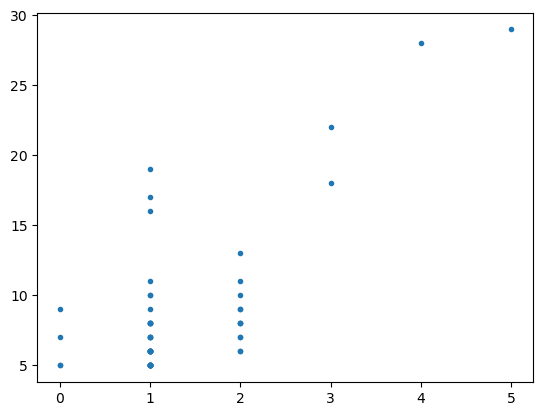

In [525]:
## A positive relationship between the number of imports and the number of lines of code.

# Task complexity as modelled by the number of imports against the number of lines required in the solution.
res = [(cell_count[test_case], line_count[test_case]) for test_case in cell_count]
plt.plot(np.transpose(res)[0], np.transpose(res)[1], '.')

In [551]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_gemini-1.5-flash-001.jsonl_results.jsonl
samples_llama3-70b-instruct-q4_0.jsonl_results.jsonl
samples_gpt-4-1106-preview.jsonl_results.jsonl
samples_codegemma-7b-instruct-fp16.jsonl_results.jsonl
samples_codellama-70b-instruct-q4_0.jsonl_results.jsonl
samples_claude-3-5-sonnet-20240620.jsonl_results.jsonl
samples_gpt-4o-2024-05-13.jsonl_results.jsonl
samples_claude-3-opus-20240229.jsonl_results.jsonl
samples_gpt-4-turbo-2024-04-09.jsonl_results.jsonl
samples_mixtral-8x7b-instruct-v0.1-q5_0.jsonl_results.jsonl
samples_command-r-plus-104b-q4_0.jsonl_results.jsonl
samples_gemini-pro.jsonl_results.jsonl
samples_gpt-3.5-turbo-1106.jsonl_results.jsonl
samples_mixtral-8x22b-instruct-v0.1-q4_0.jsonl_results.jsonl
samples_llama3-8b-instruct-fp16.jsonl_results.jsonl
samples_reference.jsonl_results.jsonl
samples_llama3-70b-instruct-q8_0.jsonl_results.jsonl
samples_codellama.jsonl_results.jsonl
samples_phi3-3.8b-mini-instruct-4k-fp16.jsonl_results.jsonl


In [526]:
df = pd.concat(collection)
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

pivot_df.head()

df = pivot_df
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)
sorted_means = df.transpose().iloc[1:].mean().sort_values(ascending=False)
df["Average_Task_Score"] = df.iloc[:,1:-1].mean(axis=1) # excludes the reference
task_score_df = pd.merge(df, task_df, left_on="task_id", right_index=True)
task_score_df.head()

,task_id,claude-3-5-sonnet-20240620,claude-3-opus-20240229,codegemma-7b-instruct-fp16,codellama,codellama-70b-instruct-q4_0,command-r-plus-104b-q4_0,gemini-1.5-flash-001,gemini-pro,gpt-3.5-turbo-1106,...,llama3-70b-instruct-q4_0,llama3-70b-instruct-q8_0,llama3-8b-instruct-fp16,mixtral-8x22b-instruct-v0.1-q4_0,mixtral-8x7b-instruct-v0.1-q5_0,phi3-3.8b-mini-instruct-4k-fp16,reference,Average_Task_Score,Lines_in_Solution,Number_of_Imports
0,apply_otsu_threshold_and_count_postiive_pixels,0.0,0.0,0.6,0.0,0.0,0.2,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.050000,10,2
1,binary_closing,1.0,1.0,0.2,0.0,0.1,0.1,0.0,0.0,0.1,...,0.7,0.5,0.1,0.5,0.3,0.2,1.0,0.372222,6,2
2,binary_skeleton,0.8,0.6,0.5,0.1,0.1,0.0,0.0,0.0,0.1,...,0.3,0.2,0.0,0.0,0.2,0.0,1.0,0.305556,5,1
3,bland_altman,1.0,1.0,0.8,0.2,0.3,0.1,1.0,0.6,1.0,...,1.0,1.0,0.5,0.9,0.5,0.8,1.0,0.761111,11,1
4,combine_columns_of_tables,1.0,0.1,0.3,0.1,0.2,0.3,0.3,0.7,0.9,...,1.0,0.9,0.1,0.9,0.7,0.5,1.0,0.577778,8,1


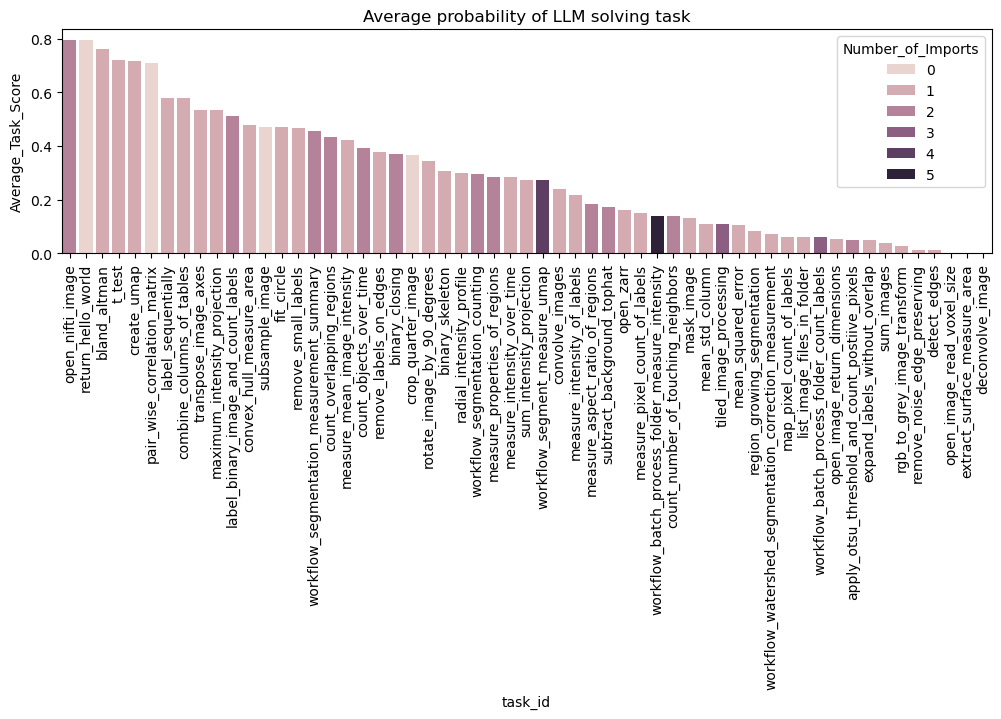

In [560]:
## Illustrating the difference in task solve rate across all LLMs.
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(task_score_df.sort_values(by="Average_Task_Score",ascending=False), x="task_id", y="Average_Task_Score", hue="Number_of_Imports").set_title('Average probability of LLM solving task')
ax.tick_params(axis='x', labelrotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
fig.savefig("../Task_Score_by_LLMs.png") 
# for item in tasks.get_xticklabels():
#     item.set_rotation(45)

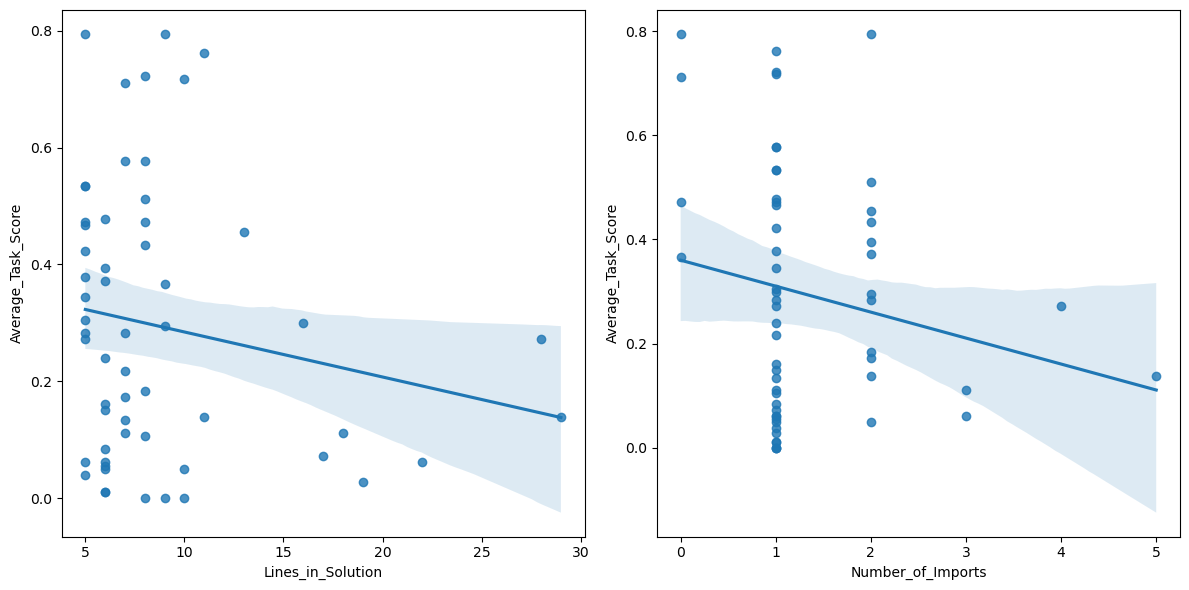

In [573]:
## Average task score as measured across all models, when regressed against the number of lines in each solution
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.regplot(task_score_df, x="Lines_in_Solution", y="Average_Task_Score", ax=axs[0])
sns.regplot(task_score_df, x="Number_of_Imports", y="Average_Task_Score", ax=axs[1])
plt.tight_layout()
fig.savefig("../Average_Task_Score_by_Complexity.png") 

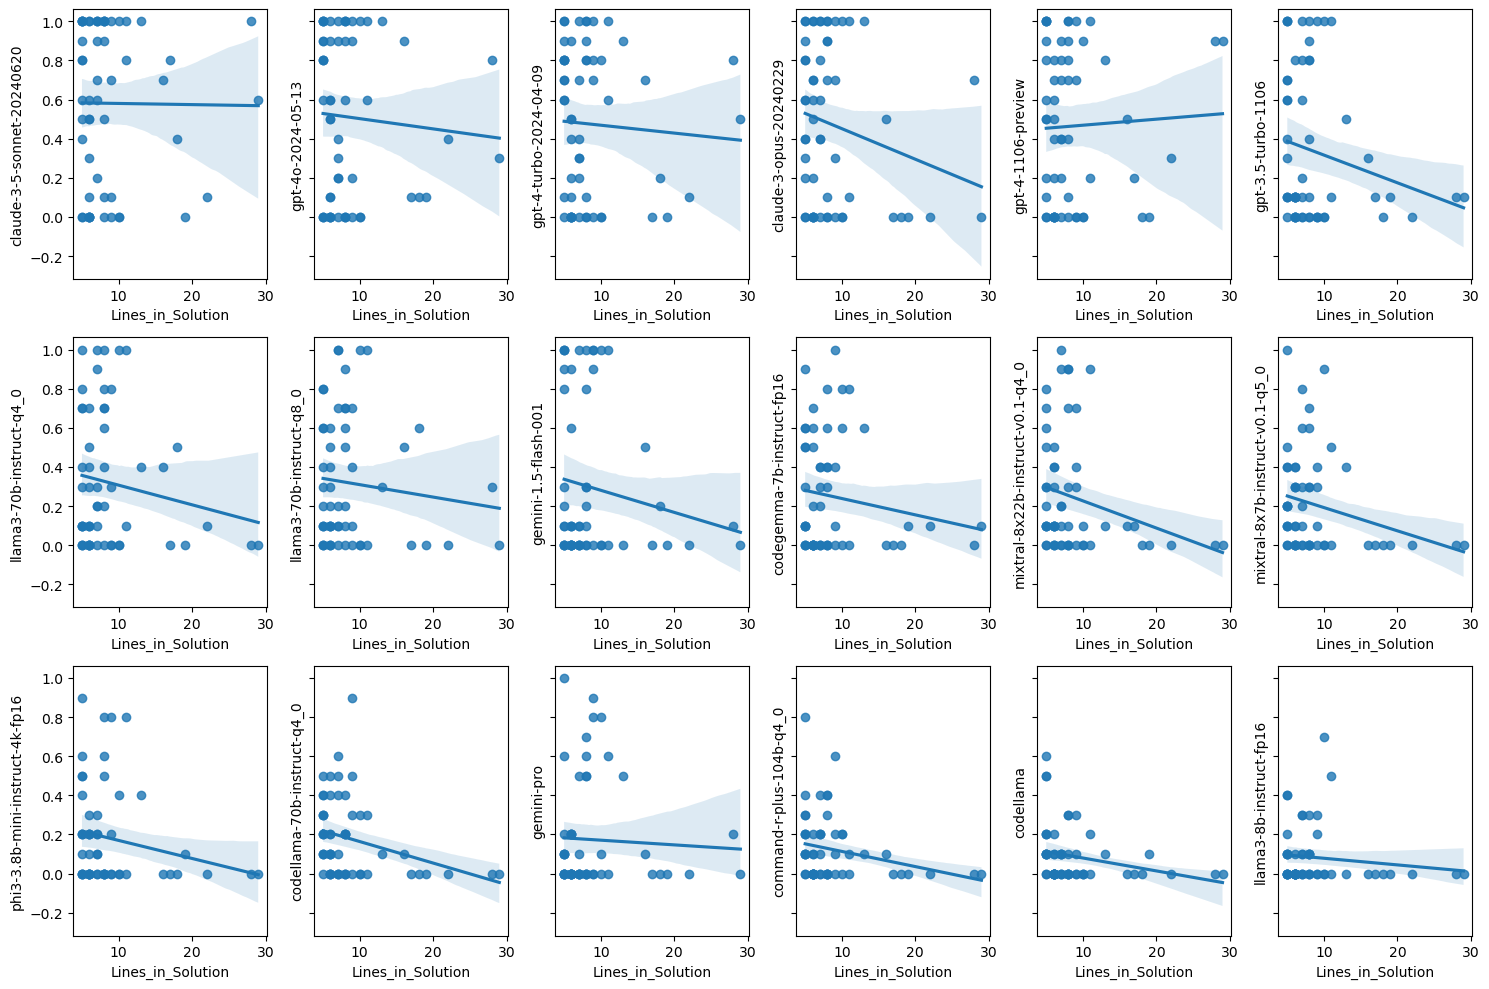

In [576]:
mean_values_ordered_names = mean_values.index.tolist()[1:]
fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(15,10), sharey=True)

for enum, colname in enumerate(mean_values_ordered_names):
    ax = axs.flatten()[enum]
    sns.regplot(task_score_df, x="Lines_in_Solution", y=colname, ax=ax)
#    ax.plot(task_score_df["Lines_in_Solution"], task_score_df[colname], '.')
#    ax.plot(
#    sns.regplot(task_score_df
plt.tight_layout()
fig.savefig("../LLMs_Complex_Problems_Lines.png") 

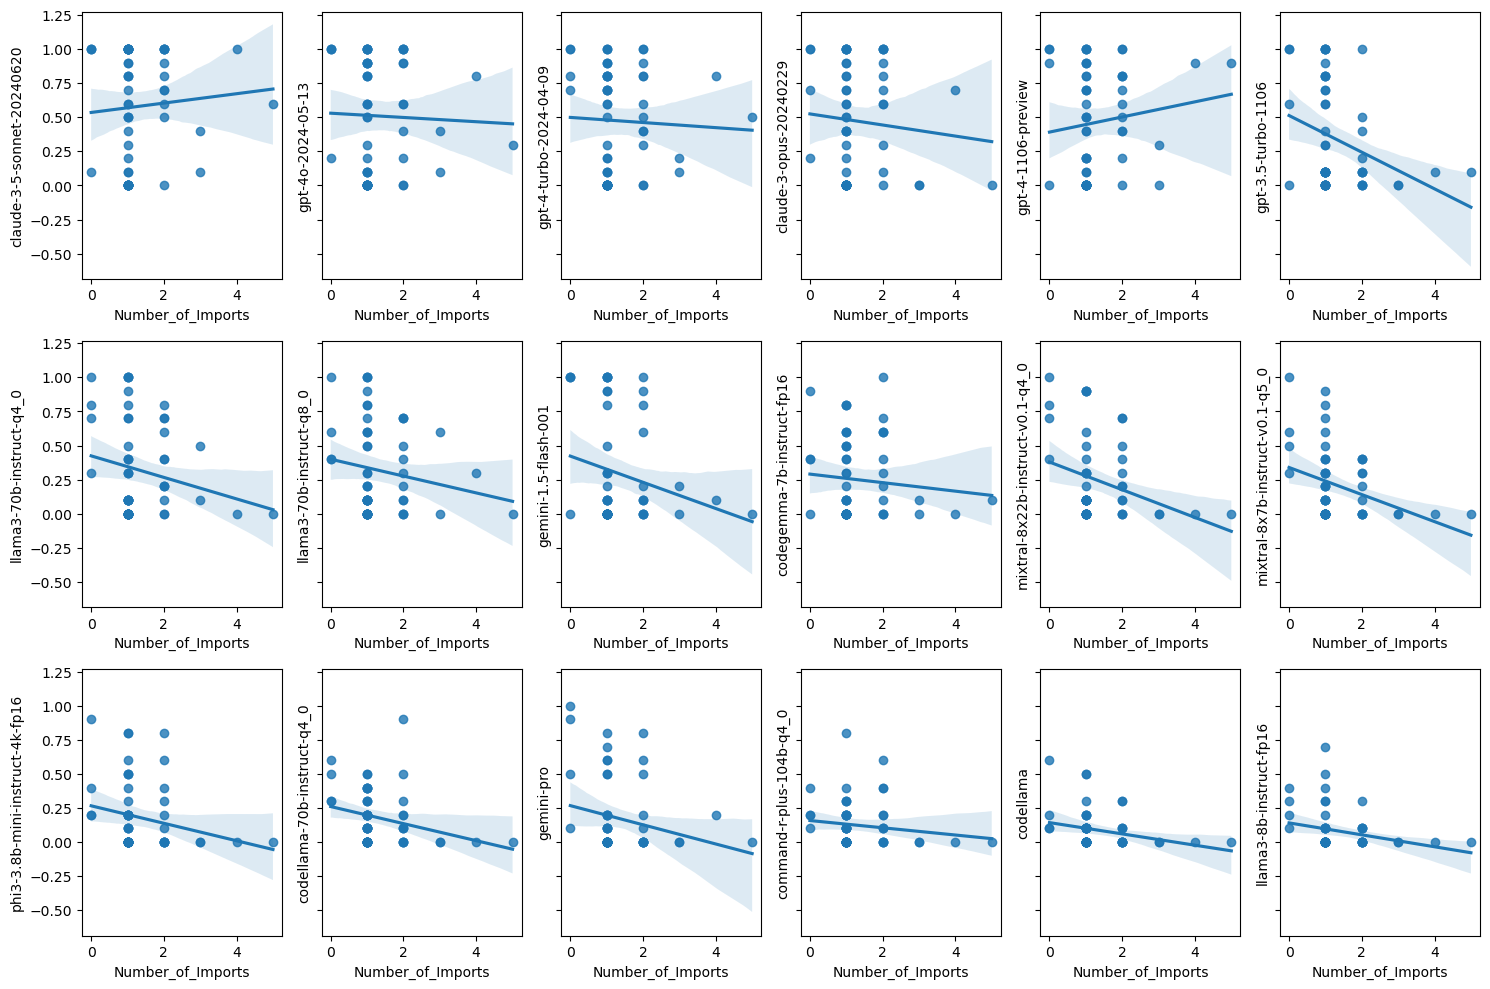

In [577]:
fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(15,10), sharey=True)

for enum, colname in enumerate(mean_values_ordered_names):
    ax = axs.flatten()[enum]
    sns.regplot(task_score_df, x="Number_of_Imports", y=colname, ax=ax)

plt.tight_layout()
fig.savefig("../LLMs_Complex_Problems_Imports.png") 